In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import math
import pandas as pd
import numpy as np
import pickle
from pymongo import MongoClient
import matplotlib.pyplot as plt

sys.path.append("src/main/python")
from load_data import load

In [97]:
df = load(10000)
print df.shape
df.head()

100 documents loaded
200 documents loaded
300 documents loaded
400 documents loaded
500 documents loaded
600 documents loaded
700 documents loaded
800 documents loaded
900 documents loaded
1000 documents loaded
1100 documents loaded
1200 documents loaded
1300 documents loaded
1400 documents loaded
1500 documents loaded
1600 documents loaded
1700 documents loaded
1800 documents loaded
1900 documents loaded
2000 documents loaded
2100 documents loaded
2200 documents loaded
2300 documents loaded
2400 documents loaded
2500 documents loaded
2600 documents loaded
2700 documents loaded
2800 documents loaded
2900 documents loaded
3000 documents loaded
3100 documents loaded
3200 documents loaded
3300 documents loaded
3400 documents loaded
3500 documents loaded
3600 documents loaded
3700 documents loaded
3800 documents loaded
3900 documents loaded
4000 documents loaded
4100 documents loaded
4200 documents loaded
4300 documents loaded
4400 documents loaded
4500 documents loaded
4600 documents load

,date,lang,lang_prob,lat,likes,locid,locname,long,mid,tags,tags_count,text,type,uid,url,text_cleaned,text_length,tag_length,tt_ratio
0,2015-10-09 15:18:00,tl,0.999997,NaN,0,None,None,NaN,1092061359292804955_2229281274,,0,Dragon Ball,image,2229281274,https://scontent.cdninstagram.com/hphotos-xaf1...,Dragon Ball,11,0,0.083333
1,2015-10-03 23:05:59,ar,0.999998,NaN,3,None,None,NaN,1087948245658768288_2222155003,,0,دعم الحساابب كلكم عندها @Njood0e_506الكل كندها...,image,2222155003,https://scontent.cdninstagram.com/hphotos-xaf1...,دعم الحساابب كلكم عندها @Njood0e_506الكل كندها...,96,0,0.010309
2,2015-10-01 10:42:47,en,0.999995,NaN,6,None,None,NaN,1086124630688729295_2218635065,,0,{ 1-10-15 } \nhi or hey?,image,2218635065,https://scontent.cdninstagram.com/hphotos-xfa1...,{ 1-10-15 } \nhi or hey?,23,0,0.041667
3,2015-08-12 17:52:57,??,0.000000,NaN,11,None,None,NaN,1050102353617662782_2127917987,,0,😊,video,2127917987,https://scontent.cdninstagram.com/hphotos-xfa1...,😊,2,0,0.333333
4,2015-08-14 14:15:14,??,0.000000,NaN,12,None,None,NaN,1051442324355801991_2027900631,,0,,image,2027900631,https://scontent.cdninstagram.com/hphotos-xaf1...,,0,0,1.000000


??    3792
en    2302
es     447
pt     342
tr     251
de     234
ru     197
it     195
no     150
ko     147
dtype: int64


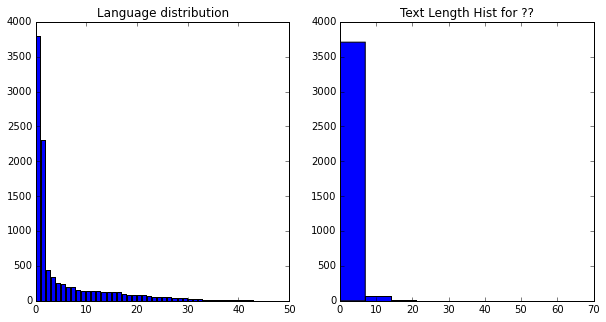

In [98]:
# Language distributions.  Seems like there are alot of unknown
cnts = df["lang"].value_counts()
print cnts[:10]
fig = plt.figure(figsize = (10, 5))
# Show language distribution
ax = fig.add_subplot(1, 2, 1)
ax.bar(range(len(cnts)), cnts)
ax.set_title("Language distribution")
# Show text length distribution for unknown
ax = fig.add_subplot(1, 2, 2)
ax.hist(list(df.loc[df["lang"] == "??"]["text_length"]))
ax.set_title("Text Length Hist for ??")
plt.show()

In [99]:
airports_df = pd.read_csv("src/main/resources/airports.dat", sep=":")
airports_df = airports_df.loc[airports_df['LongDir'] == 'U']
airports_df.loc[airports_df['LongDir'] == 'U', 'Long'] = -airports_df['Long']
airports_df.loc[airports_df['LatDir'] == 'S', 'Lat'] = -airports_df['Lat']
airports_df = airports_df.loc[:, ["Airport", "City", "Lat", "Long"]]
print airports_df.shape
print airports_df.loc[airports_df['City'] == 'USA'].head()

def closest_airport(r):
    res = pd.Series()
    if pd.notnull(r['lat']) and pd.notnull(r['long']):
        x = pd.Series([ math.sqrt((r['lat']-x['Lat'])**2 + (r['long']-x['Long'])**2) for i,x in airports_df.iterrows() ])
        res = airports_df.iloc[x.idxmin(), :]
    return res

# We define a city to be a place that has an airport, so do some additional work to attach a location to
# the nearest airport
df[["airport", "city", "city_lat", "city_long"]] = df.apply(closest_airport, axis=1)
print df.shape

(6910, 4)
            Airport City  Lat  Long
KABI        ABILENE  USA   32   -99
KABQ    ALBUQUERQUE  USA    0     0
KACK      NANTUCKET  USA   41   -70
KACT           WACO  USA   31   -97
KACY  ATLANTIC CITY  USA   39   -74
(10000, 23)


In [100]:
# What are the top cities/airports?
print df['airport'].value_counts().head()
print df['city'].value_counts().head()

MONT-DE-MARSAN    99
VALENCIA          68
LONDON            60
CANTON ISLAND     49
ADRAR             47
dtype: int64
FRANCE     148
USA        126
ENGLAND     94
SPAIN       84
ALGERIA     83
dtype: int64


In [101]:
# Create our bag of words
df['tags_cleaned'] = [ ' '.join([ 'tag:'+y for y in x.split(' ') if len(x.strip()) > 0 ]) for x in df['tags'] ]
df['bow'] = [ x['text_cleaned'] + ' ' + x['tags_cleaned'] for i,x in df.iterrows() ]

# Let's play with only english language captions for now
en_df = df.loc[(df["lang"] == "en") | (df["lang"] == "??")]
en_df.loc[[ len(x.strip()) > 0 for x in en_df['bow']], ["bow", "airport"]].head()

,bow,airport
2,{ 1-10-15 } \nhi or hey?,NaN
3,😊,NaN
20,She 's Name is Kitty,NaN
30,89 :) :*,NaN
49,Enjoy the little things n.n,NaN


(310, 20416)
                                                 bow  \
0             😘😘            😂😂😂  These guys 😏    
3            Sunrise a few months ago... No filte...   
4  Best day of my life! Nice to meet you @drakebe...   
5                  Baby running after you is like...   
6                                  Découvrez mon ...   

                                           loc         uid  
0                                               1456307594  
3                                                314090947  
4                                               2224563405  
5                                                522489847  
6  ESSADOUIRA:1|CASABLANCA:2|KORHOGO:1|RABAT:1  1499903144  


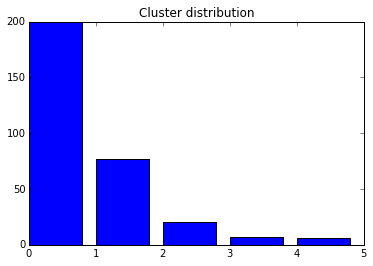

(310, 3)
--------------------------------------------------------------------------------
-- Cluster 1: N=200.000000
                                                  bow  \
0              😘😘            😂😂😂  These guys 😏    
3             Sunrise a few months ago... No filte...   
4   Best day of my life! Nice to meet you @drakebe...   
5                   Baby running after you is like...   
6                                   Découvrez mon ...   
7   Time to duty :)) Im so excited for 5 sos tour ...   
8         Shake the ....    You should be here  No...   
9                       #GoodNight 😉 #Latepost☺ t...   
10  me and my classmate . best friendship😘  It is...   
14      morning picture of him 💋💋❤❤❤❤  hellow  t...   

                                            loc         uid  cluster  
0                                                1456307594        1  
3                                                 314090947        1  
4                                                222

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

data = { 'uid': [], 'bow': [], 'loc': [] }
for k,vs in en_df.groupby('uid').groups.iteritems():
    data['uid'].append(k)
    locs = [ '%s:%d' % (k,v) for k,v in dict(en_df.loc[vs]['airport'].value_counts()).items() ]
    data['loc'].append('|'.join(locs))
    data['bow'].append(' '.join(en_df.loc[vs]['bow']))

df = pd.DataFrame(data)
df = df.loc[[ len(x.strip()) > 0 for x in df['bow'] ]]

tfidf = TfidfVectorizer(stop_words='english', norm='l2', ngram_range=[1,2])
Y = tfidf.fit_transform(df['bow'])

print Y.shape
print df.head()

k = 5
km = KMeans(k)
Y_clusters = km.fit_predict(Y)
plt.bar(range(k), pd.Series(Y_clusters).value_counts())
plt.title("Cluster distribution")
plt.show()

print df.shape
df['cluster'] = Y_clusters

Y_loc = []
# Accumulate all of the locations for each cluster
for cid in pd.unique(df['cluster']):
    locations = {}
    line = '|'.join(df.loc[df['cluster'] == cid]['loc'])
    for z in [ x.strip() for x in line.split('|') if len(x.strip()) > 0 ]:
        k,v = z.split(':')
        k = k.replace('.', '')
        if k not in locations:
            locations[k] = 0
        locations[k] = locations[k] + int(v)
    Y_loc.append({ 'cid': cid, 'locations': locations })
    
print '-' * 80
for i,cid in enumerate(pd.unique(df['cluster'])):
    print "-- Cluster %d: N=%f" % (int(cid), df.loc[df['cluster'] == cid].shape[0])
    print df.loc[df['cluster'] == cid][:10]
    print "-- Cluster Record: " + str(Y_loc[i])
    print

In [110]:
# Save off everything

host = "localhost"
port = 27017
db = "instagram"
coll = "text"

client = MongoClient(host, port)
mongo = client[db][coll]

for r in Y_loc:
    mongo.update_one({ '_id': r['cid'] }, { '$set': r }, upsert = True)
print "Saved location records"
    
tfidf_path = "tfidf.pickle"
km_path = "km.pickle"
with open(tfidf_path, 'w') as f_tfidf, open(km_path, 'w') as f_km:
    pickle.dump(tfidf, f_tfidf)
    pickle.dump(km, f_km)
    print "Saved tfidf and km models"

Saved location records
Saved tfidf and km models
